# Microarray data 2

60 samples

## Load packages

In [95]:
setwd("~/work/fibroblast_timecourse")

In [96]:
source("R/002_helper_functions.R")

In [97]:
pacman::p_load(
  fractional,
  dendsort,
  patchwork,
  stringr,
  foreach,
  doMC,
  RColorBrewer,
  data.table,
  reshape2,
  R.utils,
  rjson,
  RCurl,
  scales,
  ggrepel,
  matrixStats,
  viridis,
  dplyr,
  pheatmap,
  seriation,
  janitor
)

pacman::p_load(
  biomaRt,
  limma,
  oligo,
  hgu133plus2.db,
  RSQLite,
  DBI
)
  

sort_hclust <- function(...) { as.hclust(dendsort(as.dendrogram(hclust(...)))) }

Sys.setenv(R_THREADS = 12)
registerDoMC(cores = 12)

In [98]:
theme_set(theme_classic(base_size = 18) %+replace% theme(
  axis.line.y      = element_line(colour = "black", size = 0.2),
  axis.line.x      = element_line(colour = "black", size = 0.2),
  axis.ticks       = element_line(colour = "black", size = 0.2),
  panel.border     = element_rect(size = 0.2, fill = NA),
  strip.background = element_rect(size = 0.2)
))

## Load data

In [99]:
CEL_FILES <- Sys.glob("data-raw/microarray-data-2/cel/*.cel.gz")
length(CEL_FILES)
print(CEL_FILES[1:5])

[1] 48

[1] "data-raw/microarray-data-2/cel/NUID-0000-0163-0775.cel.gz"
[2] "data-raw/microarray-data-2/cel/NUID-0000-0163-0776.cel.gz"
[3] "data-raw/microarray-data-2/cel/NUID-0000-0163-0777.cel.gz"
[4] "data-raw/microarray-data-2/cel/NUID-0000-0163-0778.cel.gz"
[5] "data-raw/microarray-data-2/cel/NUID-0000-0163-0779.cel.gz"


In [100]:
# -----------------------------------------------------------------------------
# Retrieve the phenoData from a table.
# Interesting variables:
# ----------------------
# BioSample.name
# Passage
# Cell.line.name
# Stimulus
# Donor
# Disease
# IL6

meta <- read.delim(
  file = "data-raw/microarray-data-2/phenodata.txt",
  stringsAsFactors = FALSE
)
vars <- c(
  "Array.experiment.NUID", "BioSample.name", "Passage", "Cell.line.name", "Stimulus", "Donor",
  "Disease", "IL6"
)
meta <- meta[ , colnames(meta) %in% vars]

# BL = Baseline = start of the experiment
# none = no stimulation, end of the experiment
meta[str_detect(meta$BioSample.name, "BL"), ]$Stimulus = "Baseline"
meta[str_detect(meta$BioSample.name, "none"), ]$Stimulus = "None"
meta$Disease = substr(meta$Disease, 1, 5)
meta$Stimulus = str_replace(meta$Stimulus, "\\+", "_")
for (v in vars) {
  meta[, v] = as.factor(meta[, v])
}

meta <- clean_names(meta)
meta$biosample_name <- NULL
colnames(meta) <- c("sample", "passage", "cell_line", "stimulation", "donor", "disease", "IL6")

# Put meta in the same order as the CEL files.
cel_samples <- str_split_fixed(str_split_fixed(CEL_FILES, "cel/", 2)[,2], ".cel", 2)[,1]

stopifnot(all(cel_samples == meta$samples))

labs <- data.frame(
  Columns = colnames(meta),
  labelDescription = c(
    "Sample name",
    "Passage number: 6, 7, or 8",
    "Cell line name",
    "Stimulus applied to the cells",
    "Donor identifier: OA502, OA6, RA32, or RA449",
    "Disease: Osteoarthritis or Rheumatoid arthritis",
    "IL6 response: high or low"
  )
)
pd <- AnnotatedDataFrame(meta, labs)

head(meta)

sample,passage,cell_line,stimulation,donor,disease,IL6
NUID-0000-0163-0775,6,OA6 FLS,TNF_IL17,OA6,Osteo,high
NUID-0000-0163-0776,7,OA6 FLS,None,OA6,Osteo,high
NUID-0000-0163-0777,7,OA6 FLS,TNF,OA6,Osteo,high
NUID-0000-0163-0778,7,OA6 FLS,TNF_IL17,OA6,Osteo,high
NUID-0000-0163-0779,8,OA6 FLS,None,OA6,Osteo,high
NUID-0000-0163-0780,8,OA6 FLS,TNF,OA6,Osteo,high


In [101]:
meta_colors <- list(
  "stimulation" = c(
    "Baseline" = 'white',
    "None"     = 'grey70',
    "TNF"       = '#FEB24C',
    "TNF_IL17"  = '#E31A1C'
  )
)

In [102]:
head(meta)

sample,passage,cell_line,stimulation,donor,disease,IL6
NUID-0000-0163-0775,6,OA6 FLS,TNF_IL17,OA6,Osteo,high
NUID-0000-0163-0776,7,OA6 FLS,None,OA6,Osteo,high
NUID-0000-0163-0777,7,OA6 FLS,TNF,OA6,Osteo,high
NUID-0000-0163-0778,7,OA6 FLS,TNF_IL17,OA6,Osteo,high
NUID-0000-0163-0779,8,OA6 FLS,None,OA6,Osteo,high
NUID-0000-0163-0780,8,OA6 FLS,TNF,OA6,Osteo,high


In [103]:
cat(sprintf("%s.cel.gz", meta$sample), sep = "\n")

NUID-0000-0163-0775.cel.gz
NUID-0000-0163-0776.cel.gz
NUID-0000-0163-0777.cel.gz
NUID-0000-0163-0778.cel.gz
NUID-0000-0163-0779.cel.gz
NUID-0000-0163-0780.cel.gz
NUID-0000-0163-0781.cel.gz
NUID-0000-0163-0782.cel.gz
NUID-0000-0163-0783.cel.gz
NUID-0000-0163-0784.cel.gz
NUID-0000-0163-0785.cel.gz
NUID-0000-0163-0786.cel.gz
NUID-0000-0163-0787.cel.gz
NUID-0000-0163-0788.cel.gz
NUID-0000-0163-0789.cel.gz
NUID-0000-0163-0790.cel.gz
NUID-0000-0163-0791.cel.gz
NUID-0000-0163-0792.cel.gz
NUID-0000-0163-0793.cel.gz
NUID-0000-0163-0794.cel.gz
NUID-0000-0163-0795.cel.gz
NUID-0000-0163-0796.cel.gz
NUID-0000-0163-0797.cel.gz
NUID-0000-0163-0798.cel.gz
NUID-0000-0163-0799.cel.gz
NUID-0000-0163-0800.cel.gz
NUID-0000-0163-0801.cel.gz
NUID-0000-0163-0802.cel.gz
NUID-0000-0163-0803.cel.gz
NUID-0000-0163-0804.cel.gz
NUID-0000-0163-0805.cel.gz
NUID-0000-0163-0806.cel.gz
NUID-0000-0163-0807.cel.gz
NUID-0000-0163-0808.cel.gz
NUID-0000-0163-0809.cel.gz
NUID-0000-0163-0810.cel.gz
NUID-0000-0163-0811.cel.gz
N

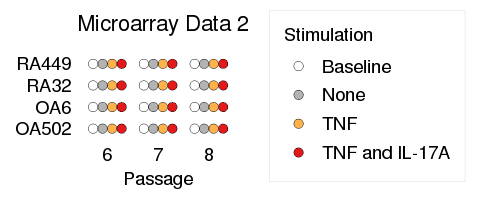

In [104]:
p <- ggplot() +
geom_point(
  data = meta,
  mapping = aes(x = passage, y = donor, group = stimulation, fill = stimulation),
  shape = 21, stroke = 0.2,
  size = 2.5,
  position = position_dodge(width = 0.75)
) +
scale_fill_manual(
  name = "Stimulation",
  values = meta_colors$stimulation,
  labels = c("Baseline", "None", "TNF", "TNF and IL-17A")
) +
theme(
  legend.background = element_rect(colour = "grey80", size = 0.1),
  title = element_text(size = 11),
  axis.ticks.length = unit(0, "cm"),
  axis.text = element_text(size = 11, color = "black"),
  legend.text = element_text(size = 11),
  panel.border = element_blank(),
  axis.line.x = element_blank(),
  axis.line.y = element_blank(),
  axis.ticks = element_blank()
) +
labs(title = "Microarray Data 2", x = "Passage", y = NULL)

options(repr.plot.width = 4, repr.plot.height = 1.7)
show_plot(p, name = "microarray-data-2-design")

## Robust Multi-array Averaging (RMA)

In [105]:
microarray_data_file <- "data/microarray-data-2.rda"

if (file.exists(microarray_data_file)) {
  load(microarray_data_file)
} else {
  rawData <- oligo::read.celfiles(CEL_FILES, phenoData = pd)
  rmaData <- oligo::rma(rawData)
  plmFit  <- oligo::fitProbeLevelModel(rawData)
  save(list = c("rawData", "rmaData", "plmFit"), file = microarray_data_file)
}

rmaExp <- exprs(rmaData)

Platform design info loaded.


Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0775.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0776.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0777.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0778.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0779.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0780.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0781.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0782.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0783.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0784.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0785.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0786.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0787.cel.gz
Reading in : data-raw/microarray-data-2/cel/NUID-0000-0163-0788.cel.gz
Readin

Warning message in oligo::read.celfiles(CEL_FILES, phenoData = pd):
“'channel' automatically added to varMetadata in phenoData.”

Background correcting
Normalizing
Calculating Expression


Background correcting... OK
Normalizing... OK
Summarizing... OK
Extracting...
  Estimates... OK
  StdErrors... OK
  Weights..... OK
  Residuals... OK
  Scale....... OK


In [106]:
options(repr.plot.width = 6.5, repr.plot.height = 3)

boxplot(rawData, main = "Raw Data", cex.axis = 1.2, cex.lab = 1.2, target = "core")

boxplot(rmaData, main = "RMA Data", cex.axis = 1.2, cex.lab = 1.2, target = "core")

ERROR: Error in file(con, "rb"): cannot open the connection


Plot with title “Raw Data”

ERROR: Error in file(con, "rb"): cannot open the connection


Plot with title “RMA Data”

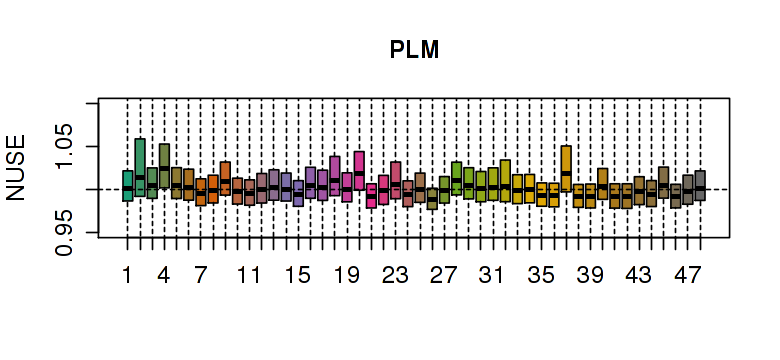

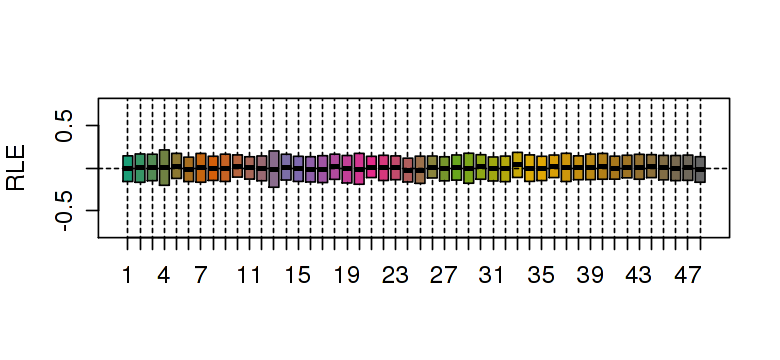

In [16]:
# Normalized Unscaled Standard-Errors (NUSE), should be distributed around 1
NUSE(plmFit, main = "PLM", cex.axis = 1.2, cex.lab = 1.2)

# Relative Log-Expression (RLE), should be distributed around 0
RLE(plmFit, cex.axis = 1.2, cex.lab = 1.2)

In [17]:
rmaExp[1:5,1:5]

,1,2,3,4,5
1007_s_at,9.333330,9.336766,9.200997,9.336742,9.811173
1053_at,8.967804,8.360850,8.641779,8.259643,8.588528
117_at,6.732569,6.636760,6.347943,6.404281,6.326498
121_at,6.971258,6.456208,6.924206,7.016922,6.508583
1255_g_at,3.416362,3.365297,3.198647,3.213606,3.525532


## BioMart takes 30-40 minutes

Running on `cn003` and should be done sometime today....

In [18]:
# mart_dat_file <- "data/microarray-data-2-biomart.rds"

# array_name <- "affy_hg_u133_plus_2"

# if (file.exists(mart_dat_file)) {
#   mart_dat <- readRDS(mart_dat_file)
# } else {
#   mart <- useMart("ensembl", dataset="hsapiens_gene_ensembl")
#   mart_dat <- getBM(
#     mart       = mart,
#     values     = rownames(rmaData),
#     filters    = c(array_name),
#     attributes = c(
#       array_name,
#       "gene_biotype", "chromosome_name", "start_position", "end_position", "strand",
#       "ensembl_gene_id", "entrezgene", "hgnc_id", "hgnc_symbol"
#     )
#   )
#   saveRDS(mart_dat, mart_dat_file)
# }

# allowed_biotypes <- c("protein_coding", "lincRNA")
# mart_dat <- subset(mart_dat, gene_biotype %in% allowed_biotypes)

# # Filter out patches, contigs, and novel segments.
# allowed_chroms <- as.character(c(1:22, "X", "Y", "MT"))
# mart_dat <- subset(mart_dat, chromosome_name %in% allowed_chroms)

# # How many probesets do not map to an Ensembl Gene ID?
# mart_dat <- unique(mart_dat[!is.na(mart_dat$ensembl_gene_id), ])

# # Dictionaries for converting probeset identifiers to other identifiers.
# probeset_to_ensembl <- split(mart_dat$ensembl_gene_id, mart_dat[[array_name]])
# probeset_to_ensembl <- sapply(probeset_to_ensembl, paste, collapse = ';')
# # Exclude probesets that map to multiple Ensembl IDs.
# probeset_to_ensembl <- probeset_to_ensembl[grep(";", probeset_to_ensembl, invert = TRUE)]
# message(length(probeset_to_ensembl), " probesets with Ensembl Gene IDs")

# mart_dat <- mart_dat[mart_dat[[array_name]] %in% names(probeset_to_ensembl),]
# message(nrow(mart_dat), " rows in mart_dat")

# probeset_to_symbol <- split(mart_dat$hgnc_symbol, mart_dat[[array_name]])
# probeset_to_symbol <- sapply(probeset_to_symbol, function(x) { paste(unique(x), collapse = ';') })
# print(head(probeset_to_symbol))

# # ensembl_to_symbol <- unlist(split(mart_dat$hgnc_symbol, mart_dat$ensembl_gene_id))
# ensembl_to_symbol <- with(unique(mart_dat[,c("hgnc_symbol", "ensembl_gene_id")]), unlist(split(hgnc_symbol, ensembl_gene_id)))
# print(head(ensembl_to_symbol))

In [19]:
# genes <- readr::read_tsv("data-raw/microarray-data-2/pilot_annotations.txt.gz")

# head(genes)

# # Dictionaries for converting probeset identifiers to other identifiers.
# probeset_to_entrez <- split(genes$EntrezGeneID, genes$ProbesetID)
# # probeset_to_entrez <- sapply(probeset_to_entrez, paste, collapse = ';')
# # Exclude probesets that map to multiple Ensembl IDs.
# # probeset_to_entrez <- probeset_to_entrez[grep(";", probeset_to_entrez, invert = TRUE)]
# # message(length(probeset_to_entrez), " probesets with Ensembl Gene IDs")
# probeset_to_entrez <- unlist(probeset_to_entrez)
# x <- names(probeset_to_entrez)
# probeset_to_entrez <- as.character(probeset_to_entrez)
# names(probeset_to_entrez) <- x

# length(probeset_to_entrez)

# print(head(probeset_to_entrez))

In [20]:
probeset_to_ensembl <- unlist(as.list(hgu133plus2ENSEMBL[mappedkeys(hgu133plus2ENSEMBL)]))
print(head(probeset_to_ensembl))

# hgu133plus2_dbInfo()

          1053_at            117_at            121_at         1255_g_at 
"ENSG00000049541" "ENSG00000173110" "ENSG00000125618" "ENSG00000048545" 
          1316_at           1320_at 
"ENSG00000126351" "ENSG00000070778" 


In [21]:
rmaExp[1:5,1:5]

,1,2,3,4,5
1007_s_at,9.333330,9.336766,9.200997,9.336742,9.811173
1053_at,8.967804,8.360850,8.641779,8.259643,8.588528
117_at,6.732569,6.636760,6.347943,6.404281,6.326498
121_at,6.971258,6.456208,6.924206,7.016922,6.508583
1255_g_at,3.416362,3.365297,3.198647,3.213606,3.525532


In [22]:
table(rownames(rmaData) %in% names(probeset_to_ensembl))


FALSE  TRUE 
16226 38449 

In [23]:
dat <- rmaExp[rownames(rmaExp) %in% names(probeset_to_ensembl),]
dat_rows <- rownames(dat)
dat <- data.table(dat)
head(dat)
dat$agg_var <- probeset_to_ensembl[dat_rows]
d_mean <- dat[, lapply(.SD, mean), by = agg_var, .SDcols = 1:48]

dim(rmaExp)
dim(d_mean)

1,2,3,4,5,6,7,8,9,10,⋯,39,40,41,42,43,44,45,46,47,48
8.967804,8.360850,8.641779,8.259643,8.588528,8.674981,8.024302,9.209920,8.686837,9.186001,⋯,8.550275,8.693810,8.454054,8.288221,8.413368,8.674400,9.494072,8.738919,8.584290,9.161270
6.732569,6.636760,6.347943,6.404281,6.326498,6.239869,6.336845,6.155588,6.047753,6.412371,⋯,6.695840,6.371869,6.478002,6.583971,6.548206,6.379311,6.348367,6.302606,6.599044,6.406307
6.971258,6.456208,6.924206,7.016922,6.508583,6.878497,6.858650,7.084958,6.821011,6.500524,⋯,7.900827,8.215148,7.969196,6.453448,6.851222,6.631985,6.483845,7.640759,6.888262,7.083837
3.416362,3.365297,3.198647,3.213606,3.525532,3.330208,3.339503,3.077578,3.403104,2.949193,⋯,3.131003,3.741301,3.582748,3.039479,3.190704,3.290868,2.869937,3.303229,3.343694,3.184514
7.899306,7.776464,7.893956,7.579777,7.704503,7.700098,7.645179,7.639257,7.623793,7.987101,⋯,8.579588,8.304741,8.364008,8.507282,8.628566,8.046530,8.348418,8.888798,8.790061,7.990406
6.187971,6.469448,6.388923,6.120907,6.712164,6.191678,6.061852,6.100152,5.960702,6.734348,⋯,6.532211,6.673362,6.239626,6.821790,6.640175,6.775447,6.402095,6.372041,6.419643,6.344750


[1] 54675    48

[1] 18098    49

In [24]:
x <- as.matrix(d_mean[,-c("agg_var")])
rownames(x) <- d_mean$agg_var
x <- x[!is.na(rownames(x)),]
rmaExp <- x
rm(x)

rmaExp[1:5,1:5]

,1,2,3,4,5
ENSG00000049541,8.879701,8.229514,8.604127,8.318159,8.583540
ENSG00000173110,6.760682,6.399005,6.186556,6.101994,6.139234
ENSG00000125618,5.769516,5.627592,5.759441,5.928625,5.612206
ENSG00000048545,4.239316,4.336656,4.076079,4.196081,4.327161
ENSG00000126351,7.174974,7.397678,7.062165,7.208529,7.327084


In [25]:
mart <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

mart_dat_file <- "data/microarray-data-2-mart.rds"

if (file.exists(mart_dat_file)) {
  mart_dat <- readRDS(mart_dat_file)
} else {
  mart_dat <- getBM(
    mart       = mart,
    values     = rownames(rmaExp),
    filters    = c("ensembl_gene_id"),
    attributes = c(
      "ensembl_gene_id", "hgnc_symbol"
    )
  )
  saveRDS(mart_dat, mart_dat_file)
}

ensembl_to_symbol <- with(unique(mart_dat[,c("hgnc_symbol", "ensembl_gene_id")]), unlist(split(hgnc_symbol, ensembl_gene_id)))
print(head(ensembl_to_symbol))

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
       "TSPAN6"          "TNMD"          "DPM1"         "SCYL3"      "C1orf112" 
ENSG00000000938 
          "FGR" 


In [26]:
#' Get an index for extreme values in a vector.
#' @param xs A numeric vector.
#' @param low The lower quantile.
#' @param high The upper quantile.
#' @return A boolean vector indicating items below or above the quantiles.
extreme_idx <- function(xs, low = 0.005, high = 0.995) {
  qs <- quantile(xs, probs = c(low, high))
  xs < qs[1] | xs > qs[2]
}

notna    <- function(xs) xs[!is.na(xs)]
negative <- function(xs) xs[xs < 0]
positive <- function(xs) xs[xs > 0]

lt <- function(xs, x) xs[xs < x]
gt <- function(xs, x) xs[xs > x]

In [27]:
# https://stackoverflow.com/questions/31677923/set-0-point-for-pheatmap-in-r
get_breaks <- function(test, paletteLength) {
  myColor <- colorRampPalette(c("red", "white", "blue"))(paletteLength)
  # use floor and ceiling to deal with even/odd length pallette lengths
  c(
    seq(min(test), 0, length.out = ceiling(paletteLength / 2) + 1), 
    seq(max(test) / paletteLength, max(test), length.out = floor(paletteLength / 2))
  )
}

my_breaks <- function(xs, n = 20, method = 'symmetric') {
  if (method == 'symmetric') {
    neg_max <- min(xs[xs < 0])
    pos_max <- max(xs[xs > 0])
    abs_max_sign <- ifelse(abs(neg_max) > pos_max, -1, 1)
    abs_max <- max(abs(xs))
    ret_breaks <- seq(-abs_max, abs_max, length.out = n)
    ret_colors <- colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(n)
    if (abs_max_sign == 1) {
      ix <- tail(which(ret_breaks < neg_max), 1):length(ret_breaks)
      ret_breaks <- ret_breaks[ix]
      ret_colors <- ret_colors[ix]
    } else {
      ix <- 1:head(which(ret_breaks > pos_max), 1)
      ret_breaks <- ret_breaks[ix]
      ret_colors <- ret_colors[ix]
    }
  }
  list("breaks" = ret_breaks, "colors" = ret_colors)
}

# Get density of points in 2 dimensions.
# @param x A numeric vector.
# @param y A numeric vector.
# @param n Create a square n by n grid to compute density.
# @return The density within each square.
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

plot_geneset_median <- function(geneset, meta, log2tpm, ci = 0.5) {
    if (!grepl("^ENSG", geneset[1])) {
        gene <- names(which(gene_symbols %in% geneset))
        stopifnot(length(geneset) > 1)
    }
    geneset <- geneset[geneset %in% rownames(log2tpm)]
    dat <- data.frame(Time = meta[["Time"]], t(log2tpm[geneset, ]))
    x <- dat[dat$Time == 0, ]
    dat_zero <- rbind(x, x, x)
    dat <- rbind(dat, dat_zero)
    dat$Time <- factor(dat$Time)
    dat_median <- reshape2::melt(dat, id.vars = c("Time")) %>%
      group_by(Time, variable) %>% 
      summarise(mean = mean(value)) %>%
      group_by(Time) %>%
      summarise(
        median = median(mean),
        low = quantile(mean, probs = (1 - ci)/2),
        high = quantile(mean, probs = 1 - ((1 - ci)/2))
      )
    ggplot(data = dat_median, mapping = aes(x = Time, y = median, ymin = low, ymax = high, group = 1)) + 
    geom_line(size = 1) +
    geom_ribbon(alpha = 0.15, fill = "black", color = NA) +
    theme_bw(base_size = font_size) + 
    labs(x = "Hours", y = bquote("Log"[2] ~ "TPM")) +
    theme(
      panel.grid.major = element_line(color = "grey60", size = 0.1),
      panel.grid.minor = element_blank()
    )
}

## Quality control with common genes

In [28]:
median_val <- median(rmaExp)

common_genes <- names(which(apply(
  X = rmaExp,
  MARGIN = 1,
  FUN = function(x) sum(x > median_val) > ceiling(0.9 * ncol(rmaExp))
)))

meta$common_percent <- apply(
  X = rmaExp[common_genes,],
  MARGIN = 2,
  FUN = function(x) sum(x > median_val)
) / length(common_genes)

In [29]:
meta$Sample <- colnames(rmaExp)
head(meta)

sample,passage,cell_line,stimulation,donor,disease,IL6,common_percent,Sample
NUID-0000-0163-0775,6,OA6 FLS,TNF_IL17,OA6,Osteo,high,0.9978675,1
NUID-0000-0163-0776,7,OA6 FLS,None,OA6,Osteo,high,0.9984947,2
NUID-0000-0163-0777,7,OA6 FLS,TNF,OA6,Osteo,high,0.9977421,3
NUID-0000-0163-0778,7,OA6 FLS,TNF_IL17,OA6,Osteo,high,0.9938535,4
NUID-0000-0163-0779,8,OA6 FLS,None,OA6,Osteo,high,0.9986202,5
NUID-0000-0163-0780,8,OA6 FLS,TNF,OA6,Osteo,high,0.9977421,6


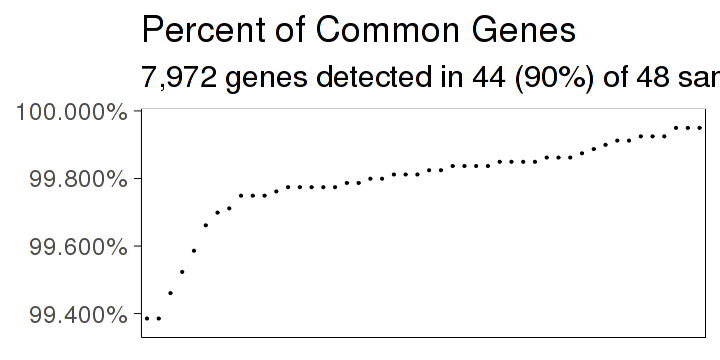

In [30]:
options(repr.plot.width = 6, repr.plot.height = 3)

ggplot(meta, aes(x = reorder(Sample, common_percent), y = common_percent, label = Sample)) +
  geom_point(size = 0.1) +
  geom_text_repel(
    data = subset(meta, common_percent < 0.99),
    nudge_x = 2,
    segment.size = 0.1,
    size = 3
  ) +
#  geom_hline(yintercept = 0.9, color = "red", linetype = 2) +
  scale_y_continuous(labels = percent, expand = c(0.1, 0)) +
  scale_x_discrete(expand = c(0.01, 0)) +
  theme(
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank(),
#    panel.grid.major.y = element_line(size = 0.03, color = 'black'),
    axis.line.x = element_blank()
  ) +
  labs(
    x = NULL, y = NULL, title = "Percent of Common Genes",
    subtitle = sprintf(
      "%s genes detected in %s (90%%) of %s samples",
      comma(length(common_genes)),
      ceiling(nrow(meta) * 0.9), nrow(meta)
    )
  )

In [31]:
subset(meta, common_percent < 0.99)

sample,passage,cell_line,stimulation,donor,disease,IL6,common_percent,Sample


In [32]:
gene_summary <- data.frame(
  mean = rowMeans(rmaExp),
  sd   = rowSds(rmaExp)
)
gene_summary$density <- with(gene_summary, get_density(mean, sd))

In [33]:
ix_exclude <- gene_summary$sd < quantile(gene_summary$sd, probs = 0.25) &
              gene_summary$mean < quantile(gene_summary$mean, probs = 0.25)

sum(ix_exclude)
sum(ix_exclude) / length(ix_exclude)

[1] 1500

[1] 0.08288209

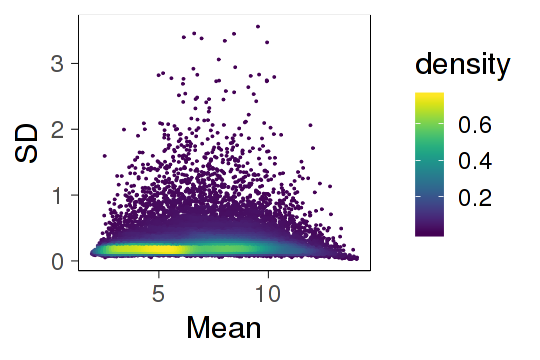

In [34]:
options(repr.plot.width = 4.5, repr.plot.height = 3)

ggplot(gene_summary[order(gene_summary$density),], aes(mean, sd, color = density)) +
scale_color_viridis() +
geom_point(size = 0.01) +
# geom_hline(yintercept = quantile(gene_summary$sd, probs = 0.25), color = "red", size = 0.2) +
# geom_vline(xintercept = quantile(gene_summary$mean, probs = 0.25), color = "red", size = 0.2) +
labs(
  x = "Mean",
  y = "SD"
#   subtitle = sprintf(
#     "Exclude %s (%s) lowly expressed genes",
#     comma(sum(ix_exclude)),
#     percent(sum(ix_exclude) / length(ix_exclude))
#   )
)

In [35]:
m_exp <- rmaExp
m_meta <- meta

In [36]:
head(m_meta)

sample,passage,cell_line,stimulation,donor,disease,IL6,common_percent,Sample
NUID-0000-0163-0775,6,OA6 FLS,TNF_IL17,OA6,Osteo,high,0.9978675,1
NUID-0000-0163-0776,7,OA6 FLS,None,OA6,Osteo,high,0.9984947,2
NUID-0000-0163-0777,7,OA6 FLS,TNF,OA6,Osteo,high,0.9977421,3
NUID-0000-0163-0778,7,OA6 FLS,TNF_IL17,OA6,Osteo,high,0.9938535,4
NUID-0000-0163-0779,8,OA6 FLS,None,OA6,Osteo,high,0.9986202,5
NUID-0000-0163-0780,8,OA6 FLS,TNF,OA6,Osteo,high,0.9977421,6


In [37]:
table(m_meta$passage, m_meta$stimulation)

   
    Baseline None TNF TNF_IL17
  6        4    4   4        4
  7        4    4   4        4
  8        4    4   4        4

# Export for NCBI GEO

In [91]:
write_matrix <- function(x, path) {
  colnames(x) <- sprintf("S%s", colnames(x))
  x <- data.frame(
    ID_REF = rownames(x),
    x,
    stringsAsFactors = FALSE
  )
  rownames(x) <- NULL
  readr::write_tsv(x, path)
}

###

out_dir <- "share/NCBI-GEO/microarray-data-2"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

rmaExp_file <- sprintf("%s/microarray-data-2_gene-expression.tsv.gz", out_dir)
write_matrix(rmaExp, rmaExp_file)

print(rmaExp_file)
cat(paste(system(sprintf("zcat %s | head | cut -f1-5 | column -t", rmaExp_file), intern = TRUE), collapse = "\n"))
cat("\n\n")

###

probeExp <- exprs(rmaData)
probeExp_file <- sprintf("%s/microarray-data-2_probe-expression.tsv.gz", out_dir)
write_matrix(probeExp, probeExp_file)

print(probeExp_file)
cat(paste(system(sprintf("zcat %s | head | cut -f1-5 | column -t", probeExp_file), intern = TRUE), collapse = "\n"))
cat("\n\n")

###

meta_cols <- c(
  "Sample",
  "donor",
  "passage",
  "IL6",
  "stimulation"
)
x <- meta[,meta_cols]
x$sample <- sprintf("S%s", x$Sample)
x$Sample <- NULL
x <- x[,c("sample", "donor", "IL6", "passage", "stimulation")]
meta_file <- sprintf("%s/microarray-data-2_metadata.tsv", out_dir)
readr::write_tsv(x, meta_file)

print(meta_file)
cat(paste(system(sprintf("cat %s | head | column -t", meta_file), intern = TRUE), collapse = "\n"))
cat("\n\n")


[1] "share/NCBI-GEO/microarray-data-2/microarray-data-2_gene-expression.tsv.gz"
ID_REF           S1                 S2                  S3                 S4
ENSG00000049541  8.879701391807236  8.229513710748321   8.60412733263852   8.318158559399988
ENSG00000173110  6.760681733978776  6.399004786328597   6.18655588724593   6.101994008660945
ENSG00000125618  5.769515842621303  5.6275917825357435  5.759441274757496  5.928624917001503
ENSG00000048545  4.239315841669887  4.336656300089474   4.076079437931257  4.196081355425469
ENSG00000126351  7.174973887936542  7.397678342248016   7.062164699244461  7.208528816100849
ENSG00000070778  6.714978955796548  6.954284875153388   6.916402855032298  6.7269312271467046
ENSG00000130649  5.853547335956081  5.7272126298023425  5.632005084570396  5.85466206727274
ENSG00000182580  5.665059686457781  6.006806409492613   5.675929440865061  5.813109245114646
ENSG00000173153  8.143348168112825  7.929581506335845   8.160117157719942  8.218745255039778

[1] 

## Linear modeling with treatment-time

In [38]:
rmaExp[1:5,1:5]

,1,2,3,4,5
ENSG00000049541,8.879701,8.229514,8.604127,8.318159,8.583540
ENSG00000173110,6.760682,6.399005,6.186556,6.101994,6.139234
ENSG00000125618,5.769516,5.627592,5.759441,5.928625,5.612206
ENSG00000048545,4.239316,4.336656,4.076079,4.196081,4.327161
ENSG00000126351,7.174974,7.397678,7.062165,7.208529,7.327084


In [39]:
m_des <- with(
  m_meta,
  model.matrix(~ stimulation)
)
colnames(m_des) <- str_replace_all(colnames(m_des), "stimulation", "")
colnames(m_des) <- str_replace_all(colnames(m_des), "\\(Intercept\\)", "Baseline")
# colnames(m_des) <- str_replace_all(colnames(m_des), "Time", "T")

m_fit <- lmFit(object = m_exp, design = m_des)
m_fit <- eBayes(m_fit)
m_fit$genes <- ensembl_to_symbol[rownames(m_fit$coefficients)]

# m_treat_cols <- grep("^dose", colnames(m_fit$coefficients), value = TRUE)
# m_time_cols  <- grep("^time", colnames(m_fit$coefficients), value = TRUE)

save(
  list = c("m_des", "m_fit", "m_exp", "m_meta"),
  file = "data/microarray-data-2-limma.rda"
)

In [40]:
m_fit_signif <- decideTests(m_fit, lfc = log2(2), p.value = 0.05)

do.call(rbind, apply(m_fit_signif, 2, function(x) {
  data.frame(
    "Up"        = sum(x == 1),
    "Down"      = sum(x == -1),
    "Unchanged" = sum(x == 0)
  )
}))

,Up,Down,Unchanged
Baseline,18098,0,0
None,3,6,18089
TNF,450,179,17469
TNF_IL17,473,260,17365


In [41]:
topTable(m_fit, coef = "TNF")

topTable(m_fit, coef = "TNF_IL17")

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000131979,GCH1,3.724523,10.580272,26.54243,1.064755e-29,1.926993e-25,56.55652
ENSG00000118503,TNFAIP3,2.843562,10.298845,22.86009,6.716647e-27,6.077894e-23,50.56353
ENSG00000138821,SLC39A8,3.261441,7.845503,21.31152,1.319235e-25,7.958507e-22,47.75049
ENSG00000077150,NFKB2,1.292231,6.370521,20.36139,8.963413e-25,2.917709e-21,45.92734
ENSG00000166348,USP54,1.758923,8.765297,20.33858,9.393710e-25,2.917709e-21,45.88260
ENSG00000146374,RSPO3,4.614369,7.947501,20.32433,9.673032e-25,2.917709e-21,45.85465
ENSG00000090339,ICAM1,3.399096,9.287439,19.43517,6.226892e-24,1.609918e-20,44.07363
ENSG00000131669,NINJ1,1.633954,9.595996,18.46631,5.119623e-23,1.158187e-19,42.04892
ENSG00000145365,TIFA,1.923501,8.048432,18.16257,1.008530e-22,2.028042e-19,41.39529
ENSG00000173114,LRRN3,4.234795,7.963400,18.01480,1.407010e-22,2.546406e-19,41.07394


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000108342,CSF3,5.333474,6.665895,28.62101,3.921862e-31,7.097785e-27,60.18957
ENSG00000105835,NAMPT,2.976370,9.918208,27.55104,2.087131e-30,1.888645e-26,58.61733
ENSG00000131979,GCH1,3.726292,10.580272,26.55504,1.042939e-29,6.291700e-26,57.09633
ENSG00000081041,CXCL2,4.321189,6.519552,26.12444,2.125680e-29,9.617637e-26,56.42078
ENSG00000077150,NFKB2,1.543404,6.370521,24.31906,4.725302e-28,1.710370e-24,53.46253
ENSG00000115009,CCL20,7.267348,8.006477,22.89588,6.282549e-27,1.895026e-23,50.97646
ENSG00000138821,SLC39A8,3.378562,7.845503,22.07684,2.963582e-26,7.662129e-23,49.47888
ENSG00000118503,TNFAIP3,2.697445,10.298845,21.68541,6.326177e-26,1.431139e-22,48.74498
ENSG00000110911,SLC11A2,1.591143,8.646284,21.53591,8.476583e-26,1.704547e-22,48.46147
ENSG00000146374,RSPO3,4.856319,7.947501,21.39002,1.129617e-25,2.044381e-22,48.18309


## TNF effects and TNF+IL17 effects

In [42]:
colnames(m_des)

[1] "Baseline" "None"     "TNF"      "TNF_IL17"

In [43]:
m_con2 <- makeContrasts(
  levels   = m_des,
  TNF_vs_None      = TNF - None,
  TNF_IL17_vs_None = TNF_IL17 - None,
  TNF_IL17_vs_TNF  = TNF_IL17 - TNF
)
m_con2 <- contrasts.fit(m_fit, m_con2)
m_con2 <- eBayes(m_con2)
m_con2$genes <- ensembl_to_symbol[rownames(m_con2$coefficients)]

topTable(m_con2, coef = "TNF_IL17_vs_TNF", confint = TRUE)

,ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000108342,CSF3,4.8572111,4.4822000,5.2322223,6.665895,26.06524,2.346185e-29,4.246126e-25,53.29588
ENSG00000163435,ELF3,3.3511038,2.9999560,3.7022516,6.064851,19.20512,1.019192e-23,9.222669e-20,42.31613
ENSG00000105792,CFAP69,1.3977818,1.2366017,1.5589619,6.688704,17.45207,5.096866e-22,3.074770e-18,38.82590
ENSG00000110944,IL23A,0.8636468,0.7557028,0.9715908,3.535327,16.10115,1.274836e-20,5.767997e-17,35.90370
ENSG00000152503,TRIM36,0.7213517,0.6297524,0.8129511,4.795544,15.84797,2.380796e-20,8.617530e-17,35.33198
ENSG00000168389,MFSD2A,1.2242814,1.0544213,1.3941415,6.616967,14.50470,7.375738e-19,2.224769e-15,32.16431
ENSG00000074603,DPP8,0.6400091,0.5485296,0.7314886,11.040899,14.07931,2.285059e-18,5.907857e-15,31.11237
ENSG00000213949,ITGA1,1.6029277,1.3541634,1.8516921,6.472764,12.96716,4.873738e-17,1.102561e-13,28.24637
ENSG00000090376,IRAK3,1.1211819,0.9435905,1.2987732,7.968347,12.70496,1.025455e-16,2.062075e-13,27.54574
ENSG00000105835,NAMPT,1.3268737,1.1094695,1.5442778,9.918208,12.28233,3.464373e-16,6.269822e-13,26.39602


In [44]:
x <- decideTests(m_con2, lfc = log2(2), p.value = 0.05)

do.call(rbind, apply(x, 2, function(x) {
  data.frame(
    "Up"        = sum(x == 1),
    "Down"      = sum(x == -1),
    "Unchanged" = sum(x == 0)
  )
}))

,Up,Down,Unchanged
TNF_vs_None,398,144,17556
TNF_IL17_vs_None,448,216,17434
TNF_IL17_vs_TNF,122,81,17895


In [45]:
dat <- do.call(rbind, lapply(c("TNF_vs_None", "TNF_IL17_vs_None", "TNF_IL17_vs_TNF"), function(this_coef) {
  retval <- topTable(m_con2, coef = this_coef, number = 1e6, confint = TRUE)
  retval$ensembl_id <- rownames(retval)
  retval$Coef <- this_coef
  retval
}))
rownames(dat) <- seq(nrow(dat))
head(dat)

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef
TNFAIP3,3.342516,3.092191,3.592840,10.298845,26.87129,6.222003e-30,8.602228e-26,57.02262,ENSG00000118503,TNF_vs_None
GCH1,3.734220,3.451830,4.016609,10.580272,26.61154,9.506274e-30,8.602228e-26,56.63468,ENSG00000131979,TNF_vs_None
NFKB2,1.435541,1.307824,1.563259,6.370521,22.61950,1.054829e-26,6.363434e-23,50.12147,ENSG00000077150,TNF_vs_None
ICAM1,3.767878,3.415917,4.119839,9.287439,21.54377,8.346917e-26,3.776563e-22,48.16942,ENSG00000090339,TNF_vs_None
NFKBIA,2.636530,2.378029,2.895030,9.855387,20.52532,6.407495e-25,2.273522e-21,46.23422,ENSG00000100906,TNF_vs_None
SLC39A8,3.128966,2.820992,3.436940,7.845503,20.44588,7.537369e-25,2.273522e-21,46.07955,ENSG00000138821,TNF_vs_None


# Export differential expression results

In [46]:
getwd()

format_numeric <- function(x, ...) {
  numeric_cols <- vapply(x, is.numeric, logical(1))
  x[numeric_cols] <- lapply(x[numeric_cols], function(x) {
    ix <- abs(x) < 0.01
    x1 <- sprintf("%.3e", x[ix])
    x2 <- sprintf("%.4f", x[!ix])
    x[ix] <- x1
    x[!ix] <- x2
    x
  })
  x
}

readr::write_tsv(
  x = format_numeric(as.data.frame(dat)),
  path = "analysis/limma/002_microarray-data-2_limma_contrasts.tsv.gz"
)

[1] "/data/srlab/slowikow/fibroblast_timecourse"

In [47]:
d <- dcast(data = dat, formula = ensembl_id ~ Coef, value.var = "logFC")
head(d)

ensembl_id,TNF_IL17_vs_None,TNF_IL17_vs_TNF,TNF_vs_None
ENSG00000000003,-0.16838781,0.33421132,-0.50259913
ENSG00000000005,0.08767749,0.06657429,0.02110320
ENSG00000000419,-0.03699915,-0.01680786,-0.02019129
ENSG00000000457,0.25855406,0.07692247,0.18163159
ENSG00000000460,0.20217445,-0.20614147,0.40831592
ENSG00000000938,0.42836322,0.07572446,0.35263876


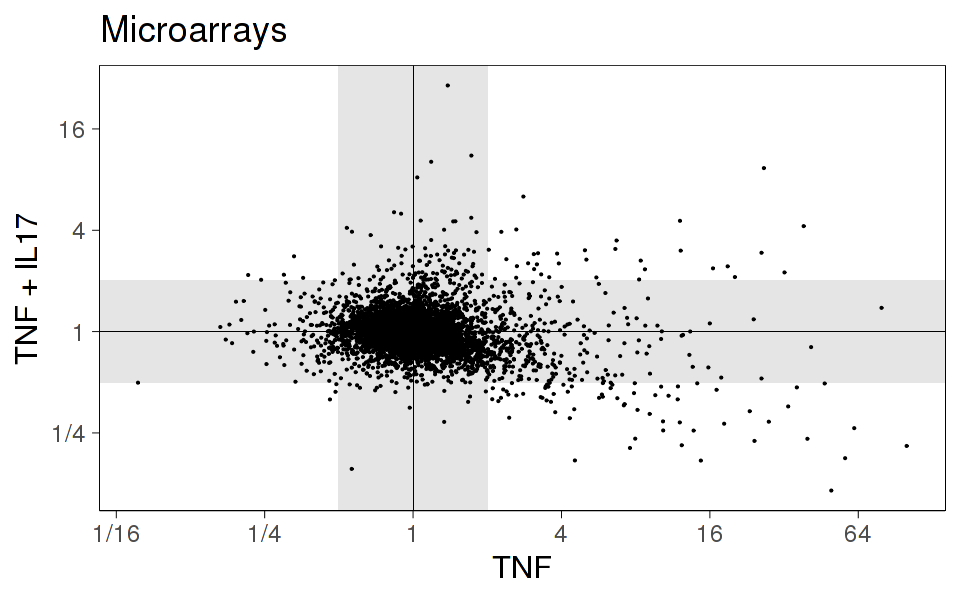

In [48]:
options(repr.plot.width = 8, repr.plot.height = 5)

d %>%
# head(100) %>%
ggplot(aes(x = TNF_vs_None, y = TNF_IL17_vs_TNF)) +
geom_rect(
  mapping = aes(
    xmin = log2(1 / 2),
    xmax = log2(2),
    ymin = -Inf,
    ymax = Inf
  ),
  fill = "grey90"
) +
geom_rect(
  mapping = aes(
    ymin = log2(1 / 2),
    ymax = log2(2),
    xmin = -Inf,
    xmax = Inf
  ),
  fill = "grey90"
) +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
geom_point(size = 0.1) +
scale_color_manual(values = c("grey50", "black")) +
theme(legend.position = "none") +
scale_x_continuous(
  breaks = pretty_breaks(5),
  labels = function(x) fractional(2^x)
) +
scale_y_continuous(
  breaks = pretty_breaks(4),
  labels = function(x) fractional(2^x)
) +
# geom_text(
#   data = subset(dat, IL17 > log2(2) & abs(TNF) > log2(2)),
#   mapping = aes(x = TNF, y = IL17, label = gene)
# ) +
labs(x = "TNF", y = "TNF + IL17", title = "Microarrays")

# Compare MA-data-1 and MA-data-2

In [49]:
library(readr)


Attaching package: ‘readr’

The following object is masked from ‘package:scales’:

    col_factor



In [50]:
col_types <- cols(
  ID = col_character(),
  logFC = col_double(),
  CI.L = col_double(),
  CI.R = col_double(),
  AveExpr = col_double(),
  t = col_double(),
  P.Value = col_double(),
  adj.P.Val = col_double(),
  B = col_double(),
  ensembl_id = col_character(),
  Coef = col_character()
)

d1 <- read_tsv("analysis/limma/002_microarray-data-1_limma_contrasts.tsv.gz", col_types = col_types)
d2 <- readr::read_tsv("analysis/limma/002_microarray-data-2_limma_contrasts.tsv.gz", col_types = col_types)

head(d1)
head(d2)

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef
NFKBIZ,0.9949,0.7592,1.2306,8.3736,8.4711,2.449e-11,4.370e-07,10.7459,ENSG00000144802,IL17_vs_MEDIA
TNFAIP6,0.5772,0.4214,0.7329,12.1548,7.4366,1.041e-09,9.284e-06,8.3928,ENSG00000123610,IL17_vs_MEDIA
CXCL1,0.8128,0.5878,1.0377,9.7649,7.2512,2.049e-09,1.218e-05,7.9554,ENSG00000163739,IL17_vs_MEDIA
NFKBIA,0.2223,0.1374,0.3071,11.2208,5.2545,2.858e-06,1.270e-02,3.0705,ENSG00000100906,IL17_vs_MEDIA
ZC3H12A,0.4467,0.2632,0.6302,8.8115,4.8865,1.037e-05,3.700e-02,2.1667,ENSG00000163874,IL17_vs_MEDIA
IL6,0.9228,0.5139,1.3317,11.2656,4.5293,3.526e-05,9.670e-02,1.3014,ENSG00000136244,IL17_vs_MEDIA


ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef
TNFAIP3,3.3425,3.0922,3.5928,10.2988,26.8713,6.222e-30,8.602e-26,57.0226,ENSG00000118503,TNF_vs_None
GCH1,3.7342,3.4518,4.0166,10.5803,26.6115,9.506e-30,8.602e-26,56.6347,ENSG00000131979,TNF_vs_None
NFKB2,1.4355,1.3078,1.5633,6.3705,22.6195,1.055e-26,6.363e-23,50.1215,ENSG00000077150,TNF_vs_None
ICAM1,3.7679,3.4159,4.1198,9.2874,21.5438,8.347e-26,3.777e-22,48.1694,ENSG00000090339,TNF_vs_None
NFKBIA,2.6365,2.3780,2.8950,9.8554,20.5253,6.407e-25,2.274e-21,46.2342,ENSG00000100906,TNF_vs_None
SLC39A8,3.1290,2.8210,3.4369,7.8455,20.4459,7.537e-25,2.274e-21,46.0795,ENSG00000138821,TNF_vs_None


In [51]:
d1$signif <- abs(d1$logFC) > log2(1.5) & d1$adj.P.Val < 0.05
d2$signif <- abs(d2$logFC) > log2(1.5) & d2$adj.P.Val < 0.05

In [52]:
table(d1$Coef)


  IL17_vs_MEDIA TNF_IL17_vs_TNF    TNF_vs_MEDIA 
          17841           17841           17841 

In [53]:
table(d2$Coef)


TNF_IL17_vs_None  TNF_IL17_vs_TNF      TNF_vs_None 
           18098            18098            18098 

In [54]:
x1 <- d1 %>% filter(Coef == "TNF_IL17_vs_TNF")
x2 <- d2 %>% filter(Coef == "TNF_IL17_vs_TNF")

ens_both <- intersect(x1$ensembl_id, x2$ensembl_id)

x1 <- x1 %>% filter(ensembl_id %in% ens_both)
x2 <- x2 %>% filter(ensembl_id %in% ens_both)

nrow(x1)
nrow(x2)

x1$data <- "ma1"
x2$data <- "ma2"

x <- rbind(x1, x2)

[1] 15666

[1] 15666

In [55]:
x %>% filter(ID == "CNKSR3")

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,signif,data
CNKSR3,-0.6147,-0.8315,-0.3979,7.4096,-5.6902,6.039e-07,0.0006369,5.8854,ENSG00000153721,TNF_IL17_vs_TNF,TRUE,ma1
CNKSR3,-0.7848,-1.0806,-0.4890,5.0327,-5.3387,2.739e-06,0.0001652,4.4698,ENSG00000153721,TNF_IL17_vs_TNF,TRUE,ma2


In [56]:
x %>% group_by(data) %>% dplyr::summarize(min = min(AveExpr), max = max(AveExpr), mean = mean(AveExpr))

data,min,max,mean
ma1,2.5685,13.5308,7.298513
ma2,1.9368,14.0480,7.062827


In [57]:
xx <- dcast(data = x, formula = ensembl_id + ID ~ data, value.var = "logFC")
xx <- xx[!is.na(xx$ma1),]
xx <- xx[!is.na(xx$ma2),]
# head(xx)

xx2 <- dcast(data = x, formula = ensembl_id + ID ~ data, value.var = "signif")
xx2 <- xx2[!is.na(xx2$ma1),]
xx2 <- xx2[!is.na(xx2$ma2),]
colnames(xx2) <- c("ensembl_id", "ID", "ma1_signif", "ma2_signif")
stopifnot(all(xx$ensembl_id == xx2$ensembl_id))

xx <- cbind(xx, xx2[,3:4])

xx$signif <- "none"
xx$signif[xx$ma1_signif & xx$ma2_signif] <- "both"
xx$signif[xx$ma1_signif & !xx$ma2_signif] <- "ma1"
xx$signif[!xx$ma1_signif & xx$ma2_signif] <- "ma2"
head(xx)

ensembl_id,ID,ma1,ma2,ma1_signif,ma2_signif,signif
ENSG00000000003,TSPAN6,0.0805000,0.3342,FALSE,FALSE,none
ENSG00000000005,TNMD,0.0280000,0.0666,FALSE,FALSE,none
ENSG00000000419,DPM1,-0.0002833,-0.0168,FALSE,FALSE,none
ENSG00000000457,SCYL3,-0.0408000,0.0769,FALSE,FALSE,none
ENSG00000000460,C1orf112,-0.0592000,-0.2061,FALSE,FALSE,none
ENSG00000000938,FGR,-0.0258000,0.0757,FALSE,FALSE,none


In [58]:
table(xx$signif)


 both   ma1   ma2  none 
   11     3   474 15102 

In [60]:
library(ggrastr)

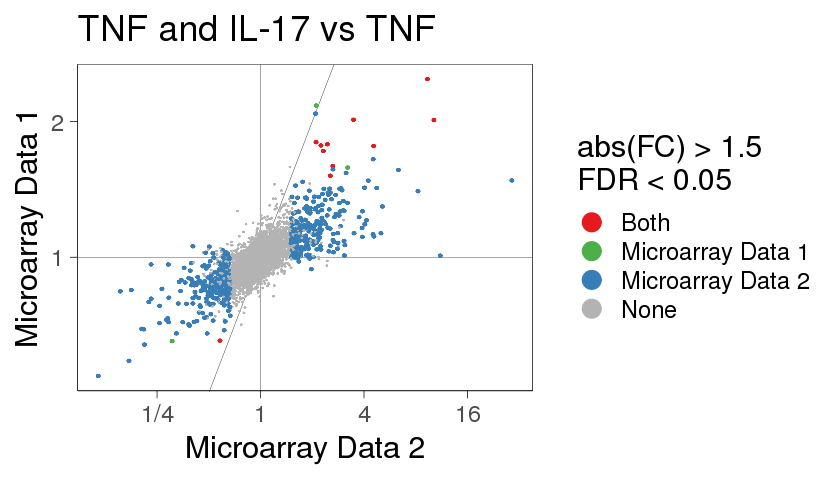

In [69]:

p <- xx %>%
# head(1000) %>%
ggplot(aes(x = ma2, y = ma1)) +
# geom_rect(
#   mapping = aes(xmin = log2(1 / 2), xmax = log2(2), ymin = -Inf, ymax = Inf),
#   fill = "grey90"
# ) +
# geom_rect(
#   mapping = aes(ymin = log2(1 / 2), ymax = log2(2), xmin = -Inf, xmax = Inf),
#   fill = "grey90"
# ) +
geom_abline(slope = 1, intercept = 0, size = 0.1) +
geom_hline(yintercept = 0, size = 0.1) +
geom_vline(xintercept = 0, size = 0.1) +
geom_point_rast(raster.width = 5,
  mapping = aes(color = signif, size = signif != "none")
) +
scale_size_manual(values = c(0.2, 1), guide = FALSE) +
scale_color_manual(
  values = c("none" = "grey70", "ma1" = '#4DAF4A', "ma2" = '#377EB8', "both" = '#E41A1C'),
  labels = c("none" = "None", "ma1" = 'Microarray Data 1', "ma2" = 'Microarray Data 2', "both" = 'Both')
) +
# scale_color_manual(values = c()) +
guides(color = guide_legend(title = "abs(FC) > 1.5\nFDR < 0.05", override.aes = aes(size = 5))) +
# theme(legend.position = "none") +
# coord_equal() +
scale_x_continuous(
  breaks = pretty_breaks(5),
  labels = function(x) fractional(2^x)
) +
scale_y_continuous(
  breaks = log2(c(0.5, 1, 2)),
  labels = function(x) fractional(2^x)
) +
labs(x = "Microarray Data 2", y = "Microarray Data 1", title = "TNF and IL-17A vs TNF")

options(repr.plot.width = 7, repr.plot.height = 4)
show_plot(p, "microarray-comparison")

In [316]:
cat(sort((xx %>% filter(signif == "both"))$ID))

ABCA8 AGPAT4 C15orf48 CCL8 CFAP69 CNKSR3 CXCL1 CXCL2 EDNRB ELF3 SEMA6D

In [301]:
cor(xx$ma1, xx$ma2) ^ 2 

[1] 0.4468339

In [298]:
cor.test(xx$ma1, xx$ma2, method = "pearson")


	Pearson's product-moment correlation

data:  xx$ma1 and xx$ma2
t = 112.21, df = 15588, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6596810 0.6770496
sample estimates:
      cor 
0.6684564 


In [294]:
?cor.test

cor.test {stats},R Documentation
"x, y",numeric vectors of data values. x and y must have the same length.
alternative,"indicates the alternative hypothesis and must be one of ""two.sided"", ""greater"" or ""less"". You can specify just the initial letter. ""greater"" corresponds to positive association, ""less"" to negative association."
method,"a character string indicating which correlation coefficient is to be used for the test. One of ""pearson"", ""kendall"", or ""spearman"", can be abbreviated."
exact,a logical indicating whether an exact p-value should be computed. Used for Kendall's tau and Spearman's rho. See ‘Details’ for the meaning of NULL (the default).
conf.level,confidence level for the returned confidence interval. Currently only used for the Pearson product moment correlation coefficient if there are at least 4 complete pairs of observations.
continuity,"logical: if true, a continuity correction is used for Kendall's tau and Spearman's rho when not computed exactly."
formula,"a formula of the form ~ u + v, where each of u and v are numeric variables giving the data values for one sample. The samples must be of the same length."
data,an optional matrix or data frame (or similar: see model.frame) containing the variables in the formula formula. By default the variables are taken from environment(formula).
subset,an optional vector specifying a subset of observations to be used.
na.action,"a function which indicates what should happen when the data contain NAs. Defaults to getOption(""na.action"")."


In [279]:
brewer.pal(9, "Set1")

[1] "#E41A1C" "#377EB8" "#4DAF4A" "#984EA3" "#FF7F00" "#FFFF33" "#A65628"
[8] "#F781BF" "#999999"

In [204]:
cor.test(xx$ma1, xx$ma2)


	Pearson's product-moment correlation

data:  xx$ma1 and xx$ma2
t = 112.21, df = 15588, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6596810 0.6770496
sample estimates:
      cor 
0.6684564 
